In [1]:
import pandas as pd
import numpy as np
import os
import polars as pl
import gc

In [2]:
df = pl.read_parquet('capstone_data.parquet')
# df.write_parquet('capstone_data.parquet', compression='gzip')

print(df.shape)
df.head()

(12294267, 54)


Month,Year,Program,Program - Network,Episode,Partner - Network,Series ID,Program ID Key,Partner - Episode,Partner - Program,Partner - Episode Duration,Partner - Name,Partner - Platform,Partner - Device,Partner - Demo,Partner - Rating Source,Partner - Viewer Code,Program - Broadcast Length,Program - Broadcast Length SSSSS,Exposures,Minutes Viewed,Program - Current Premiere Date,Program - Air Title,Program - Budget Line,Program - Category,Program - Episode Number,Program - External Air Order,Program - External Season,Program - Franchise,Program - Genre Name,Program - Is Special,Program - Mega Genre,Program - Network Name,Program - PAC ID,Program - PAC Title,Program - Premiere Network Code,Program - Production Year,Program - Type,Program - ID,Program - Status,Program - Series Code,Program - Series ID,Program - Series Name,Program - Long Form/Short Form,Program - Sub Category,Program - Supplier,Program - TMS ID,Year and Month,Partner - Data Type,Program Sub-Type,NO.of Scheduled Minutes,NO.of Telecasts,Distinct Episode,# of Episode
str,i64,str,str,str,str,f64,i64,str,str,i64,str,str,str,str,str,str,i64,i64,f64,f64,str,str,str,str,f64,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,f64,str,str,f64,str,str,str,str,str,str,str,str,i64,i64,i64,i64
"""Jan""",2022,"""Sell This House!""","""FYI""","""nightmare on windsong trail (#…","""HMN""",191.0,236912,"""Nightmare on Windsong Trail""","""""Sell This House!""""",1800,"""Wurl Vizio""","""Fast Channels""","""CTV""","""P2+""",null,null,30,1800,514.0,12483.325632,"""2020-06-01""","""Nightmare on Windsong Trail (#…","""Sell This House""","""REAL LIFE""",4.0,204.0,16.0,"""SELL THIS HOUSE""","""Reality TV""",0.0,"""LIFESTYLE""","""FYI""",36481.0,"""Sell This House 2019""","""FYI""",2020.0,"""Series""",236912.0,"""Executed""","""SELL""",191.0,"""Sell This House!""","""Long Form""","""HOME""","""Six West Originals LLC""","""EP005867900219""","""2022/01""","""VIEW_DATA""","""Unscripted""",116,4,1,1
"""Feb""",2022,"""Mountain Men""","""HIST""","""lost""","""XT Outdoor""",2368.0,77850,"""Lost""","""Mountain Men""",3600,"""Wurl Plex""","""Fast Channels""","""CTV""","""P2+""",null,null,60,3600,629.6,22839.763777,"""2012-06-14""","""Lost""","""Mountain Men""","""SKILLS & THRILLS""",3.0,3.0,1.0,"""MOUNTAIN MEN""","""Documentary""",0.0,"""ORIGINAL CHARACTER""","""The History Channel""",19945.0,"""Mountain Men""","""THC""",2012.0,"""Series""",77850.0,"""Executed""","""MMEN""",2368.0,"""Mountain Men""","""Long Form""","""SURVIVAL""","""Warm Springs Productions""","""EP015556560003""","""2022/02""","""VIEW_DATA""","""Unscripted""",204,4,1,1
"""Feb""",2022,"""Mountain Men""","""HIST""","""lost""","""XT Outdoor""",2368.0,77850,"""Lost""","""Mountain Men""",3600,"""Wurl Plex""","""Fast Channels""","""Desktop""","""P2+""",null,null,60,3600,78.7,2187.105519,"""2012-06-14""","""Lost""","""Mountain Men""","""SKILLS & THRILLS""",3.0,3.0,1.0,"""MOUNTAIN MEN""","""Documentary""",0.0,"""ORIGINAL CHARACTER""","""The History Channel""",19945.0,"""Mountain Men""","""THC""",2012.0,"""Series""",77850.0,"""Executed""","""MMEN""",2368.0,"""Mountain Men""","""Long Form""","""SURVIVAL""","""Warm Springs Productions""","""EP015556560003""","""2022/02""","""VIEW_DATA""","""Unscripted""",204,4,1,1
"""Feb""",2022,"""Mountain Men""","""HIST""","""lost""","""XT Outdoor""",2368.0,77850,"""Lost""","""Mountain Men""",3600,"""Wurl Plex""","""Fast Channels""","""Mobile""","""P2+""",null,null,60,3600,78.7,2260.501575,"""2012-06-14""","""Lost""","""Mountain Men""","""SKILLS & THRILLS""",3.0,3.0,1.0,"""MOUNTAIN MEN""","""Documentary""",0.0,"""ORIGINAL CHARACTER""","""The History Channel""",19945.0,"""Mountain Men""","""THC""",2012.0,"""Series""",77850.0,"""Executed""","""MMEN""",2368.0,"""Mountain Men""","""Long Form""","""SURVIVAL""","""Warm Springs Productions""","""EP015556560003""","""2022/02""","""VIEW_DATA""","""Unscripted""",204,4,1,1
"""Mar""",2022,"""Tiny House Nation""","""FYI""","""460 sq ft long journey to tiny…","""HMN""",399

### Prepare for Data Wrangling: Notes from Sponsor

#### Show Types to focus on: 
1. Legacy Series In-Premiere: Defined as a series with more than two season available. The new season is only available on 1st/2nd window platforms, but the library is available on 1st/2nd/3rd window platforms.
2. New Series In-Premiere: Defined as a series with less than two seasons. Generally, they are only available on 1st/2nd window platforms. If in its 2nd season, there could be a season one available on 1st/2nd/3rd window platforms, but I can’t think of any that happened like that in FY22/FY23 (aka the data you will be working with).

#### Show Types to exclude:
1. Movies/Specials
2. Non-Returning/Cancelled series (ie Dog the Bounty Hunter, and even Dance Moms eventhoug they are trying to revive that this year)


#### Ad-Sales Platforms to focus on:
1. Live +7: This drives about 90% of the total Ad-Sales P2+ mins (this data is generally complete b/c it comes from Nielsen)
2. Non-Linear: These top partners drive 80%-90% of the Ad-Sales Non-Linear P2+ Mins. Would try to ensure that the data here is complete and makes sense. I recently had to pull Ad-sales non-linear data for a presentation and attached was my data pull. Thought this would be helpful so you can see the scale of all the platforms at a high level.
    a. On Demand:
        (1) O&O
        (2) vMVPD Hulu Live: HUGE NOTE: Will explain more in person, but we have licensed a large amount of our library content to Hulu SVOD, therefore that inventory does not live on Hulu Live for ad-sales to monetize. (i.e. all Alone library lives on Hulu SVOD, and only the new Alone season is available on Hulu Live each year).
        (3) vMVPD Philo
        (4) vMVPD SlingTV
        (5) STB VOD4+ Comcast
    b. FAST: Samsung
    
#### Primary Levers to focus: 

1. Paid Media - Sent by Cristina
2. Organic Social Media (A+E under impression that Hoya 2 will retrieve this)
3. Partner Earned Media (Still pending with A+E)
4. O&O IFW Content - Sent by Cristina
5. 3rd Windowing Platforms (FAST/SVOD/AVOD) - Available via CP Data


##### Focusing on New / Returning Shows


In [3]:
# Convert the column to datetime if it's not already in datetime format
df = df.with_columns( pl.col("Program - Current Premiere Date").str.to_datetime(format="%Y-%m-%d").alias('program_current_premiere_date') )

# Extract the year
df = df.with_columns( pl.col("program_current_premiere_date").dt.year().alias("premiere_year") )

# Drop original column
df = df.drop("Program - Current Premiere Date")

print(df.shape)
df.head()

(12294267, 55)


Month,Year,Program,Program - Network,Episode,Partner - Network,Series ID,Program ID Key,Partner - Episode,Partner - Program,Partner - Episode Duration,Partner - Name,Partner - Platform,Partner - Device,Partner - Demo,Partner - Rating Source,Partner - Viewer Code,Program - Broadcast Length,Program - Broadcast Length SSSSS,Exposures,Minutes Viewed,Program - Air Title,Program - Budget Line,Program - Category,Program - Episode Number,Program - External Air Order,Program - External Season,Program - Franchise,Program - Genre Name,Program - Is Special,Program - Mega Genre,Program - Network Name,Program - PAC ID,Program - PAC Title,Program - Premiere Network Code,Program - Production Year,Program - Type,Program - ID,Program - Status,Program - Series Code,Program - Series ID,Program - Series Name,Program - Long Form/Short Form,Program - Sub Category,Program - Supplier,Program - TMS ID,Year and Month,Partner - Data Type,Program Sub-Type,NO.of Scheduled Minutes,NO.of Telecasts,Distinct Episode,# of Episode,program_current_premiere_date,premiere_year
str,i64,str,str,str,str,f64,i64,str,str,i64,str,str,str,str,str,str,i64,i64,f64,f64,str,str,str,f64,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,f64,str,str,f64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,datetime[μs],i32
"""Jan""",2022,"""Sell This House!""","""FYI""","""nightmare on windsong trail (#…","""HMN""",191.0,236912,"""Nightmare on Windsong Trail""","""""Sell This House!""""",1800,"""Wurl Vizio""","""Fast Channels""","""CTV""","""P2+""",null,null,30,1800,514.0,12483.325632,"""Nightmare on Windsong Trail (#…","""Sell This House""","""REAL LIFE""",4.0,204.0,16.0,"""SELL THIS HOUSE""","""Reality TV""",0.0,"""LIFESTYLE""","""FYI""",36481.0,"""Sell This House 2019""","""FYI""",2020.0,"""Series""",236912.0,"""Executed""","""SELL""",191.0,"""Sell This House!""","""Long Form""","""HOME""","""Six West Originals LLC""","""EP005867900219""","""2022/01""","""VIEW_DATA""","""Unscripted""",116,4,1,1,2020-06-01 00:00:00,2020
"""Feb""",2022,"""Mountain Men""","""HIST""","""lost""","""XT Outdoor""",2368.0,77850,"""Lost""","""Mountain Men""",3600,"""Wurl Plex""","""Fast Channels""","""CTV""","""P2+""",null,null,60,3600,629.6,22839.763777,"""Lost""","""Mountain Men""","""SKILLS & THRILLS""",3.0,3.0,1.0,"""MOUNTAIN MEN""","""Documentary""",0.0,"""ORIGINAL CHARACTER""","""The History Channel""",19945.0,"""Mountain Men""","""THC""",2012.0,"""Series""",77850.0,"""Executed""","""MMEN""",2368.0,"""Mountain Men""","""Long Form""","""SURVIVAL""","""Warm Springs Productions""","""EP015556560003""","""2022/02""","""VIEW_DATA""","""Unscripted""",204,4,1,1,2012-06-14 00:00:00,2012
"""Feb""",2022,"""Mountain Men""","""HIST""","""lost""","""XT Outdoor""",2368.0,77850,"""Lost""","""Mountain Men""",3600,"""Wurl Plex""","""Fast Channels""","""Desktop""","""P2+""",null,null,60,3600,78.7,2187.105519,"""Lost""","""Mountain Men""","""SKILLS & THRILLS""",3.0,3.0,1.0,"""MOUNTAIN MEN""","""Documentary""",0.0,"""ORIGINAL CHARACTER""","""The History Channel""",19945.0,"""Mountain Men""","""THC""",2012.0,"""Series""",77850.0,"""Executed""","""MMEN""",2368.0,"""Mountain Men""","""Long Form""","""SURVIVAL""","""Warm Springs Productions""","""EP015556560003""","""2022/02""","""VIEW_DATA""","""Unscripted""",204,4,1,1,2012-06-14 00:00:00,2012
"""Feb""",2022,"""Mountain Men""","""HIST""","""lost""","""XT Outdoor""",2368.0,77850,"""Lost""","""Mountain Men""",3600,"""Wurl Plex""","""Fast Channels""","""Mobile""","""P2+""",null,null,60,3600,78.7,2260.501575,"""Lost""","""Mountain Men""","""SKILLS & THRILLS""",3.0,3.0,1.0,"""MOUNTAIN MEN""","""Documentary""",0.0,"""ORIGINAL CHARACTER""","""The History Channel""",19945.0,"""Mountain Men""","""THC""",2012.0,"""Series""",77850.0,"""Executed""","""MMEN""",2368.0,"""Mountain Men""","""Long Form""","""SURVIVAL""","""Warm Springs Productions""","""EP015556560003""","""2022/02""","""VIEW_DATA""","""Unscripted""",204,4,1,1,2012-06-14 00:00:00,2012
"""Mar""",2022,"""Tiny House Nation""",""

### Identify shows with a premiere year in 2022 or 2023
Removing observations where the Program is a Special.

In [4]:
df['Program - Is Special'].value_counts()

Program - Is Special,count
f64,u32
1.0,563129
0.0,11125823
null,605315


In [5]:
df['Program - Type'].value_counts()

Program - Type,count
str,u32
"""Special""",567662
"""Series""",11121290
null,605315


In [6]:
df = df.filter( (pl.col("premiere_year").is_in([2022, 2023])) & 
                (pl.col("Program - Is Special") != 1) & 
                (pl.col("Program - Type") != "Special") &
                (pl.col("Program Sub-Type") != "Movie") &
                (pl.col("Program Sub-Type") != "Special") )

print(df.shape)
df.head()

(1124412, 55)


Month,Year,Program,Program - Network,Episode,Partner - Network,Series ID,Program ID Key,Partner - Episode,Partner - Program,Partner - Episode Duration,Partner - Name,Partner - Platform,Partner - Device,Partner - Demo,Partner - Rating Source,Partner - Viewer Code,Program - Broadcast Length,Program - Broadcast Length SSSSS,Exposures,Minutes Viewed,Program - Air Title,Program - Budget Line,Program - Category,Program - Episode Number,Program - External Air Order,Program - External Season,Program - Franchise,Program - Genre Name,Program - Is Special,Program - Mega Genre,Program - Network Name,Program - PAC ID,Program - PAC Title,Program - Premiere Network Code,Program - Production Year,Program - Type,Program - ID,Program - Status,Program - Series Code,Program - Series ID,Program - Series Name,Program - Long Form/Short Form,Program - Sub Category,Program - Supplier,Program - TMS ID,Year and Month,Partner - Data Type,Program Sub-Type,NO.of Scheduled Minutes,NO.of Telecasts,Distinct Episode,# of Episode,program_current_premiere_date,premiere_year
str,i64,str,str,str,str,f64,i64,str,str,i64,str,str,str,str,str,str,i64,i64,f64,f64,str,str,str,f64,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,f64,str,str,f64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,datetime[μs],i32
"""Jan""",2022,"""The First 48""","""AEN""","""chat trap (#447)""","""AEN""",217.0,242264,"""CHAT TRAP 447""","""THE FIRST 48""",3600,"""Nielsen""","""Live +3""",null,"""P2+""","""NCC-L3""","""LINVOD""",60,3600,1.7364e6,8.0135e7,"""CHAT TRAP (#447)""","""The First 48""","""TRUE CRIME""",13.0,550.0,22.0,"""FIRST 48""","""Real Life Series""",0.0,"""CRIME & INVESTIGATION""","""A&E Television Network""",37018.0,"""The First 48 - 30x60 season 19""","""AEN""",2021.0,"""Series""",242264.0,"""Executed""","""FR48""",217.0,"""The First 48""","""Long Form""","""REAL-LIFE HEROES""","""ITV Studios, Inc""","""EP006609610819""","""2022/01""","""VIEW_DATA""","""Unscripted""",126,2,1,1,2022-01-27 00:00:00,2022
"""Jan""",2022,"""Castle""","""LIFE""","""time will tell""","""LIFE""",6784.0,255702,"""605 TIME WILL TELL""","""CASTLE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""","""NCC-L3""","""LINVOD""",60,3600,1.4025e6,6.0163e7,"""Time Will Tell""","""Castle""",null,null,110.0,null,null,"""Dramatic Entertainment""",0.0,null,"""Lifetime Television""",38697.0,"""CASTLE - Series Acquisition""","""LFT""",2021.0,"""Series""",255702.0,"""Executed""","""CAST""",6784.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""EP010855880113""","""2022/01""","""VIEW_DATA""","""Scripted""",126,2,1,1,2022-01-18 00:00:00,2022
"""Jan""",2022,"""Castle""","""LIFE""","""the lives of others""","""LIFE""",6784.0,255692,"""519 LIVES OF OTHERS, THE""","""CASTLE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""","""NCC-L3""","""LINVOD""",60,3600,661916.187565,2.8606e7,"""The Lives of Others""","""Castle""",null,null,100.0,null,null,"""Dramatic Entertainment""",0.0,null,"""Lifetime Television""",38697.0,"""CASTLE - Series Acquisition""","""LFT""",2021.0,"""Series""",255692.0,"""Executed""","""CAST""",6784.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""EP010855880100""","""2022/01""","""VIEW_DATA""","""Scripted""",60,1,1,1,2022-01-17 00:00:00,2022
"""Jan""",2022,"""Castle""","""LIFE""","""the human factor""","""LIFE""",6784.0,255696,"""523 HUMAN FACTOR, THE""","""CASTLE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""","""NCC-L3""","""LINVOD""",60,3600,882500.870056,3.8046e7,"""The Human Factor""","""Castle""",null,null,104.0,null,null,"""Dramatic Entertainment""",0.0,null,"""Lifetime Television""",38697.0,"""CASTLE - Series Acquisition""","""LFT""",2021.0,"""Series""",255696.0,"""Executed""","""CAST""",6784.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""EP010855880108""","""2022/01""","""VIEW_DATA""","""Scripted""",120,2,1,1,2022-01-17 00:00:00,2022
"""Jan""",2022,"""Castle""","""LIFE""","""the wrong stuff""","""LIFE""",6784.0,255736,"""716 WRONG STUFF, THE""","""CASTLE""",3600,"""Niels

In [7]:
#Create new variable to establish whether season is Legacy or New

df = df.with_columns(
    pl.when(pl.col("Program - External Season") < 2)
    .then(1)
    .when(pl.col("Program - External Season") >= 2)
    .then(2)
    .otherwise(0)
    .alias("Series Type")
)

# Cast to string and replace values
df = df.with_columns(
    pl.col('Series Type')
    .cast(pl.String)
    .replace({
        '1': 'New',
        '2': 'Legacy',
        '0': 'Unknown'
    })
    .alias('Series Type')
)

df.head(2)

Month,Year,Program,Program - Network,Episode,Partner - Network,Series ID,Program ID Key,Partner - Episode,Partner - Program,Partner - Episode Duration,Partner - Name,Partner - Platform,Partner - Device,Partner - Demo,Partner - Rating Source,Partner - Viewer Code,Program - Broadcast Length,Program - Broadcast Length SSSSS,Exposures,Minutes Viewed,Program - Air Title,Program - Budget Line,Program - Category,Program - Episode Number,Program - External Air Order,Program - External Season,Program - Franchise,Program - Genre Name,Program - Is Special,Program - Mega Genre,Program - Network Name,Program - PAC ID,Program - PAC Title,Program - Premiere Network Code,Program - Production Year,Program - Type,Program - ID,Program - Status,Program - Series Code,Program - Series ID,Program - Series Name,Program - Long Form/Short Form,Program - Sub Category,Program - Supplier,Program - TMS ID,Year and Month,Partner - Data Type,Program Sub-Type,NO.of Scheduled Minutes,NO.of Telecasts,Distinct Episode,# of Episode,program_current_premiere_date,premiere_year,Series Type
str,i64,str,str,str,str,f64,i64,str,str,i64,str,str,str,str,str,str,i64,i64,f64,f64,str,str,str,f64,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,f64,str,str,f64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,datetime[μs],i32,str
"""Jan""",2022,"""The First 48""","""AEN""","""chat trap (#447)""","""AEN""",217.0,242264,"""CHAT TRAP 447""","""THE FIRST 48""",3600,"""Nielsen""","""Live +3""",null,"""P2+""","""NCC-L3""","""LINVOD""",60,3600,1.7364e6,8.0135e7,"""CHAT TRAP (#447)""","""The First 48""","""TRUE CRIME""",13.0,550.0,22.0,"""FIRST 48""","""Real Life Series""",0.0,"""CRIME & INVESTIGATION""","""A&E Television Network""",37018.0,"""The First 48 - 30x60 season 19""","""AEN""",2021.0,"""Series""",242264.0,"""Executed""","""FR48""",217.0,"""The First 48""","""Long Form""","""REAL-LIFE HEROES""","""ITV Studios, Inc""","""EP006609610819""","""2022/01""","""VIEW_DATA""","""Unscripted""",126,2,1,1,2022-01-27 00:00:00,2022,"""Legacy"""
"""Jan""",2022,"""Castle""","""LIFE""","""time will tell""","""LIFE""",6784.0,255702,"""605 TIME WILL TELL""","""CASTLE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""","""NCC-L3""","""LINVOD""",60,3600,1.4025e6,6.0163e7,"""Time Will Tell""","""Castle""",null,null,110.0,null,null,"""Dramatic Entertainment""",0.0,null,"""Lifetime Television""",38697.0,"""CASTLE - Series Acquisition""","""LFT""",2021.0,"""Series""",255702.0,"""Executed""","""CAST""",6784.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""EP010855880113""","""2022/01""","""VIEW_DATA""","""Scripted""",126,2,1,1,2022-01-18 00:00:00,2022,"""Unknown"""


### Count of missing values per column.

<br> QUESTION FOR TEAM TO CONSIDER: Topic of how the grouping of variables in the season concatenation will affect the missing value imputation.

In [8]:
df.null_count()

Month,Year,Program,Program - Network,Episode,Partner - Network,Series ID,Program ID Key,Partner - Episode,Partner - Program,Partner - Episode Duration,Partner - Name,Partner - Platform,Partner - Device,Partner - Demo,Partner - Rating Source,Partner - Viewer Code,Program - Broadcast Length,Program - Broadcast Length SSSSS,Exposures,Minutes Viewed,Program - Air Title,Program - Budget Line,Program - Category,Program - Episode Number,Program - External Air Order,Program - External Season,Program - Franchise,Program - Genre Name,Program - Is Special,Program - Mega Genre,Program - Network Name,Program - PAC ID,Program - PAC Title,Program - Premiere Network Code,Program - Production Year,Program - Type,Program - ID,Program - Status,Program - Series Code,Program - Series ID,Program - Series Name,Program - Long Form/Short Form,Program - Sub Category,Program - Supplier,Program - TMS ID,Year and Month,Partner - Data Type,Program Sub-Type,NO.of Scheduled Minutes,NO.of Telecasts,Distinct Episode,# of Episode,program_current_premiere_date,premiere_year,Series Type
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,1084,0,0,38396,18084,0,0,0,25114,0,1099475,1099475,0,0,0,0,0,3042,13513,71729,7189,5322,390360,6,0,13513,0,0,0,5187,0,0,0,0,0,0,0,0,13513,0,492,0,0,0,0,0,0,0,0,0,0


In [9]:
too_high = []
counts = {}

for col in df.columns:
    nullz = len( df.filter(pl.col(col).is_null()) )
    perc = (nullz/len(df)) * 100
    counts[col] = round(perc, 4)
    if perc >= 10:
        too_high.append(col)

#remove those with > 10% null
df = df.drop(too_high)

too_high

['Partner - Rating Source', 'Partner - Viewer Code', 'Program - Franchise']

### columns


### Program Information

1. **Program**: The title of the program or episode aired.
1. **Episode**: The specific episode of the program, often including a number or unique identifier.
1. **Program - Air Title**: The title of the program as it appeared when aired, which may differ slightly from the official title.
1. **Program - Series Name**: The name of the series to which the program belongs.
1. **Program - Type**: Indicates the type of programming, such as series, movie, or special event.
1. **Program - Category**: Broad classification of the program, such as drama, reality, or documentary.
1. **Program - Sub Category**: A more specific categorization within the main category.
1. **Program - Genre Name**: The specific genre of the program, providing more detail than the category.
1. **Program - Mega Genre**: A broader category that encompasses multiple genres.
1. **Program - Long Form/Short Form**: Indicates whether the program is a long-form (typically over 30 minutes) or short-form production.

### Broadcast Details

1. **Month** and **Year**: The month and year when the program aired.
1. **Program - Network**: The network that broadcast the program.
1. **Program - Network Name**: The full, official name of the broadcasting network.
1. **Program - Broadcast Length**: The duration of the broadcast in seconds.
1. **Program - Broadcast Length SSSSS**: The broadcast length in HH:MM:SS format.
1. **Program - Premiere Network Code**: A code indicating the network where the program first premiered.
1. **Program - Production Year**: The year in which the program was produced.
1. **program_current_premiere_date**: The most recent premiere date of the program.
1. **premiere_year**: The year when the episode or series first premiered.

### Episode and Series Information

1. **Program - Episode Number**: The episode's number within its series.
1. **Program - External Air Order**: The order in which the episode aired, which may differ from its production order.
1. **Program - External Season**: The season number of the program as listed in external sources.
1. **Program - Is Special**: Indicates whether the episode is a special presentation (0 for no, 1 for yes).
1. **Series Type**: Classifies the series as scripted, unscripted, or other types.
1. **Program Sub-Type**: Further classification of the program, such as mini-series or documentary.

### Identification and Tracking

1. **Series ID**: A unique identifier for the series.
1. **Program ID Key**: A unique key assigned to the specific program.
1. **Program - ID**: Another unique identifier for the program.
1. **Program - PAC ID**: An ID assigned by the Program Allocation Committee (PAC).
1. **Program - PAC Title**: The title of the program as recorded by the PAC.
1. **Program - Series Code**: A code representing the series.
1. **Program - Series ID**: Another identifier corresponding to the series.
1. **Program - TMS ID**: A unique identifier from the TMS (Tribune Media Services) database.

### Viewership and Performance

1. **Exposures**: The number of times the program was viewed by audiences.
1. **Minutes Viewed**: The total number of minutes viewed by all audiences for this program.
1. **NO.of Scheduled Minutes**: The total number of minutes the program was scheduled to air.
1. **NO.of Telecasts**: The number of times the program was broadcast.
1. **Distinct Episode**: Indicates whether this is a unique episode (usually 1 for yes). This kind of classification is useful in media and broadcasting analytics to differentiate between original episodes and reruns or syndicated content.
1. **# of Episode**: A count or identifier for the episode within the dataset.

### Partner Information

1. **Partner - Network**: The network of the partner associated with this program.
1. **Partner - Episode**: The title of the episode as listed by the partner network.
1. **Partner - Program**: The program title as listed by the partner network.
1. **Partner - Episode Duration**: The duration of the episode according to the partner.
1. **Partner - Name**: The name of the partner network or platform.
1. **Partner - Platform**: The distribution platform used by the partner (e.g., cable, streaming).
1. **Partner - Device**: The type of device used for viewing (e.g., TV, mobile, desktop).
1. **Partner - Demo**: The target demographic for the program.
1. **Partner - Data Type**: The type of data reported by the partner.

### Production and Business Information

1. **Program - Budget Line**: The budget allocation or category for the program.
1. **Program - Status**: The current status of the program (e.g., in production, completed, cancelled).
1. **Program - Supplier**: The company or entity that supplied the content.
1. **Year and Month**: A combined field showing both the year and month of airing.


In [29]:
nulls_dict = df.null_count().to_dicts()

for dtype, col in zip(df.dtypes, df.columns):
    print(col, '--', dtype, '--', nulls_dict[0][col])

Month -- String -- 0
Year -- Int64 -- 0
Program -- String -- 0
Program - Network -- String -- 0
Episode -- String -- 0
Partner - Network -- String -- 1084
Series ID -- Float64 -- 0
Program ID Key -- Int64 -- 0
Partner - Episode -- String -- 38396
Partner - Program -- String -- 18084
Partner - Episode Duration -- Int64 -- 0
Partner - Name -- String -- 0
Partner - Platform -- String -- 0
Partner - Device -- String -- 25114
Partner - Demo -- String -- 0
Program - Broadcast Length -- Int64 -- 0
Program - Broadcast Length SSSSS -- Int64 -- 0
Exposures -- Float64 -- 0
Minutes Viewed -- Float64 -- 0
Program - Air Title -- String -- 0
Program - Budget Line -- String -- 3042
Program - Category -- String -- 13513
Program - Episode Number -- Float64 -- 71729
Program - External Air Order -- Float64 -- 7189
Program - External Season -- Float64 -- 5322
Program - Genre Name -- String -- 6
Program - Is Special -- Float64 -- 0
Program - Mega Genre -- String -- 13513
Program - Network Name -- String -- 

### decide which columns would be irrelevant to a model:

- Program - Status
- Partner - Episode
- Partner - Program
- Partner - Data Type
- Program - TMS ID
- Program - Series ID
- Program - Series Code
- Program - PAC Title
- Program - PAC ID
- Program - ID
- Program ID Key
- Series ID
- Program - Is Special (already filtered)
- Program - Type (already filtered)
- Program - Premiere Network Code
- Program - Broadcast Length SSSSS  (we already have Program - Broadcast Length which is a better model format)


In [33]:
irrel_cols = ['Program - Status','Partner - Episode','Partner - Program','Partner - Data Type','Program - TMS ID','Program - Series ID',
              'Program - Series Code','Program - PAC Title','Program - PAC ID','Program - ID','Program ID Key','Series ID',
              'Program - Is Special','Program - Type','Program - Premiere Network Code','Program - Broadcast Length SSSSS']

df = df.drop(irrel_cols)

df.head()

Month,Year,Program,Program - Network,Episode,Partner - Network,Partner - Episode Duration,Partner - Name,Partner - Platform,Partner - Device,Partner - Demo,Program - Broadcast Length,Exposures,Minutes Viewed,Program - Air Title,Program - Budget Line,Program - Category,Program - Episode Number,Program - External Air Order,Program - External Season,Program - Genre Name,Program - Mega Genre,Program - Network Name,Program - Production Year,Program - Series Name,Program - Long Form/Short Form,Program - Sub Category,Program - Supplier,Year and Month,Program Sub-Type,NO.of Scheduled Minutes,NO.of Telecasts,Distinct Episode,# of Episode,program_current_premiere_date,premiere_year,Series Type
str,i64,str,str,str,str,i64,str,str,str,str,i64,f64,f64,str,str,str,f64,f64,f64,str,str,str,f64,str,str,str,str,str,str,i64,i64,i64,i64,datetime[μs],i32,str
"""Jan""",2022,"""The First 48""","""AEN""","""chat trap (#447)""","""AEN""",3600,"""Nielsen""","""Live +3""",null,"""P2+""",60,1.7364e6,8.0135e7,"""CHAT TRAP (#447)""","""The First 48""","""TRUE CRIME""",13.0,550.0,22.0,"""Real Life Series""","""CRIME & INVESTIGATION""","""A&E Television Network""",2021.0,"""The First 48""","""Long Form""","""REAL-LIFE HEROES""","""ITV Studios, Inc""","""2022/01""","""Unscripted""",126,2,1,1,2022-01-27 00:00:00,2022,"""Legacy"""
"""Jan""",2022,"""Castle""","""LIFE""","""time will tell""","""LIFE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""",60,1.4025e6,6.0163e7,"""Time Will Tell""","""Castle""",null,null,110.0,null,"""Dramatic Entertainment""",null,"""Lifetime Television""",2021.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""2022/01""","""Scripted""",126,2,1,1,2022-01-18 00:00:00,2022,"""Unknown"""
"""Jan""",2022,"""Castle""","""LIFE""","""the lives of others""","""LIFE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""",60,661916.187565,2.8606e7,"""The Lives of Others""","""Castle""",null,null,100.0,null,"""Dramatic Entertainment""",null,"""Lifetime Television""",2021.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""2022/01""","""Scripted""",60,1,1,1,2022-01-17 00:00:00,2022,"""Unknown"""
"""Jan""",2022,"""Castle""","""LIFE""","""the human factor""","""LIFE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""",60,882500.870056,3.8046e7,"""The Human Factor""","""Castle""",null,null,104.0,null,"""Dramatic Entertainment""",null,"""Lifetime Television""",2021.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""2022/01""","""Scripted""",120,2,1,1,2022-01-17 00:00:00,2022,"""Unknown"""
"""Jan""",2022,"""Castle""","""LIFE""","""the wrong stuff""","""LIFE""",3600,"""Nielsen""","""Live +3""",null,"""P2+""",60,894878.109494,3.8472e7,"""The Wrong Stuff""","""Castle""",null,null,144.0,null,"""Dramatic Entertainment""",null,"""Lifetime Television""",2021.0,"""Castle""","""Long Form""",null,"""Buena Vista""","""2022/01""","""Scripted""",126,2,1,1,2022-01-31 00:00:00,2022,"""Unknown"""


### Per Babak's suggestion do clustering which will allow us to fill in a lot of nulls based on which cluster a null record belongs to

In [34]:
df = df.with_columns(pl.col("program_current_premiere_date").dt.epoch(time_unit="s").alias("program_current_premiere_date")) #convert datetime to seconds for ease of modeling
#df = df_with_epoch.with_columns( pl.from_epoch("program_current_premiere_date", time_unit="s").alias("program_current_premiere_date") ) #how to convert from epoch seconds back to datetime

In [54]:
import polars as pl
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
from kneed import KneeLocator

In [40]:
# Select numeric columns
numeric_columns = df.select(pl.exclude(pl.String)).columns
numeric_columns

['Year',
 'Partner - Episode Duration',
 'Program - Broadcast Length',
 'Exposures',
 'Minutes Viewed',
 'Program - Episode Number',
 'Program - External Air Order',
 'Program - External Season',
 'Program - Production Year',
 'NO.of Scheduled Minutes',
 'NO.of Telecasts',
 'Distinct Episode',
 '# of Episode',
 'program_current_premiere_date',
 'premiere_year']

In [42]:
categorical_columns  = df.select(pl.col(pl.String)).columns
categorical_columns

['Month',
 'Program',
 'Program - Network',
 'Episode',
 'Partner - Network',
 'Partner - Name',
 'Partner - Platform',
 'Partner - Device',
 'Partner - Demo',
 'Program - Air Title',
 'Program - Budget Line',
 'Program - Category',
 'Program - Genre Name',
 'Program - Mega Genre',
 'Program - Network Name',
 'Program - Series Name',
 'Program - Long Form/Short Form',
 'Program - Sub Category',
 'Program - Supplier',
 'Year and Month',
 'Program Sub-Type',
 'Series Type']

In [51]:
#  pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# fit preprocessor and transform data
X_preprocessed = preprocessor.fit_transform(df)

In [58]:
# get best num of clusters using elbow method
inertia = []
k_range = range(1, 21)

for k in k_range:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_preprocessed)
    inertia.append(kmeans.inertia_)

# KneeLocator to find the elbow point
kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
elbow_point = kl.elbow

elbow_point #9 is best

np.int64(9)

<Axes: >

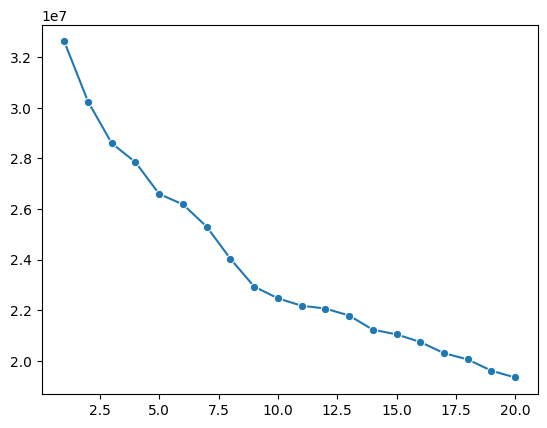

In [62]:
sns.lineplot(x=k_range, y=inertia, marker='o')

In [74]:
# clustering 
optimal_kmeans = KMeans(n_clusters=int(elbow_point), random_state=42)
cluster_labels = optimal_kmeans.fit_predict(X_preprocessed)

df = df.with_columns(pl.Series('Cluster', cluster_labels))

In [70]:
def fill_nulls_by_cluster(df, column):

    cluster_modes = df.groupby('Cluster')[column].mode().to_dict() # get mode for each cluster
    
    # Fill nulls
    return df[column].fill_null(df['Cluster'].map_dict(cluster_modes))

# Apply null filling to all columns
for column in df.columns:
    if df[column].null_count() > 0:
        df = df.with_columns(fill_nulls_by_cluster(df, column).alias(column))

array([8, 8, 5, ..., 2, 2, 2], dtype=int32)

### #Filling NAs with "Unknown" and 0 for purposes of grouping. 
Beforehand, the grouping was removing Linear variables because they had missing values in one category

In [ ]:
for col, dtype in zip(df.columns, df.dtypes):
    print(col, '--', dtype)

In [ ]:
# Fill NaN with 'Unknown' for categorical/object columns
df_filled_str = df.select(pl.col(pl.String).fill_null('Unknown'))
df_filled_int32 = df.select(pl.col(pl.Int32).fill_null(0))
df_filled_int64 = df.select(pl.col(pl.Int64).fill_null(0))
df_filled_float = df.select(pl.col(pl.Float64).fill_null(0.0))
df_filled_other = df.select( pl.exclude([pl.Int64, pl.Float64, pl.Int32, pl.String]) )
df_filled = pl.concat([df_filled_str, df_filled_int32, df_filled_int64, df_filled_float, df_filled_other], how="horizontal")

print(df.shape, df_filled.shape)
df_filled.head()

In [ ]:
df_filled.null_count()

In [ ]:
#Drop columns relevant to the episode
df_filled = df_filled.drop(['Program - Episode Number','Program - External Air Order','Episode','# of Episode','Distinct Episode',
                      'Year and Month','Month','Partner - Episode','Program - Air Title','Program - Budget Line'])


In [ ]:
#pretty low unkown numbers among the categorical columns
categorical_columns = df_filled.select(pl.col(pl.String)).columns

counts = {}
for col in categorical_columns:
    unk = len( df_filled.filter(pl.col(col) == 'Unknown') )
    perc = (unk/len(df_filled)) * 100
    counts[col] = round(perc, 4)

counts

In [ ]:
#looks like  'Program - Franchise' has 34% unknown. let's toss it

In [ ]:
agg_cols = ['Program', 'Program - Network', 'Partner - Network', 'Partner - Program', 
             'Partner - Name', 'Partner - Platform', 'Partner - Device', 'Partner - Demo',
             'Program - Category', 'Program - Franchise', 'Program - Genre Name', 
             'Program - Mega Genre', 'Program - Network Name', 'Program - PAC Title', 
             'Program - Premiere Network Code', 'Program - Status', 'Program - Series Code', 
             'Program - Series Name', 'Program - Long Form/Short Form', 'Program - Sub Category',
             'Program - Supplier', 'Program - TMS ID', 'Partner - Data Type', 'Program Sub-Type',
             'Series Type', 'premiere_year','Year','Series ID','Program ID Key',
             'Program - External Season','Program - PAC ID','Program - Production Year',
             'Program - ID', 'Program - Series ID']

aggregated_seasons = df_filled.group_by(agg_cols).agg(
    pl.col('Partner - Episode Duration').sum().alias("sum - Episode Duration"),
    pl.col('Program - Broadcast Length').sum().alias("sum - Program - Broadcast Length"),
    pl.col('Program - Broadcast Length SSSSS').sum().alias("sum - Program - Broadcast Length SSSSS"),
    pl.col('Exposures').sum().alias("sum - Exposures"),
    pl.col('Minutes Viewed').sum().alias("sum - Minutes Viewed"),
    pl.col('NO.of Scheduled Minutes').sum().alias("sum - NO.of Scheduled Minutes"),
    pl.col('NO.of Telecasts').sum().alias("sum - NO.of Telecasts"),
)
aggregated_seasons